# <center>Eye Tracking Project</center>

## Table of Contents

1. [Import Requirements](#Import-Requirements)
2. [Context Information](#Context-information)
3. [Paper 1: IPA](#The-Index-of-Pupillary-Activity)
    1. [Version 1](#Version-1) Hardcoded Version 
    2. [Version 2](#Version-2) PyWavelet Version
5. [Paper 2: LHIPA](#The-Low/High-Index-of-Pupillary-Activity)
6. [Paper 3: RIPA](#Toward-a-Real-Time-Index-of-Pupillary-Activity)
7. [PyPil Base Class](#Base-Class)
    1. [IPA Subclass](#IPA-Subclass)
    2. [LHIPA Subclass](#LHIPA-Subclass)
    3. [RIPA Theorectical Implementation](#Theoretical-Implementation)
8. [Lindlbauer Datasets](#Applied-to-the-Lindlbauer-Datasets)

## Import Requirements
These are the required packages to make the program work, I tried to limit it to only what was found within the original pseudocode with only a few additional ones where I thought they would be best used.

In [1]:
import glob
import math
import numpy as np
import os
import pandas as pd
import pywt

from matplotlib import pyplot as plt

## Context information
I will be trying to implement three pupillometric measures from Duchowski's papers regarding: 
- 1) Index of Pupillary Activity (IPA)
- 2) Low/High Index of Pupillary Activity (LHIPA)
- 3) Reat-Time-Index of Pupillary Activity (RIPA) 

Which are all loosely based on Marshall's Index of Cognitive Activity (ICA) from 2002.

## The Index of Pupillary Activity
The paper Duchowski et al. (2018) is the basis for this and it is the first iteration of their eye-tracked measure of the requency of pupil diameter oscillation. What this paper achieves is creating/replicating the Index of Cognitive Activity (ICA) and in general improving upon it without necessarily being copyrighted. 


## Version 1
This version was created before I was aware that PyWavelet could do 90% of what I needed for the code. This can be found on the Github under Unmaintained Code as Python Implementation v1. But is otherwise not up to date.

## Version 2
This version is the final one that is used within the implementation and is far cleaner code because of it.

### IPA Implementation
There are roughly six formulas that are used within the paper to calculate IPA. Below we will go through each one and how they are implemented, what their variables are, and how they connect to one another. 


### Wavelet Decomposition
All of the five formulas listed below construct the first part of our python implementation from the Duchowski et al. (2018) paper. Each of them will be noted in their explicit part in the end result but are as such not hardcode calculated in this current version of the project.

#### Dyadic Wavelet Function
The first of many functions, this one represents the wavelet function used in the analysis and is representative of the $wavelet$ argument in the function. For this specific rendition of the code, we assume that they are using the "sym16" version as that is what is used within the pseudo-code.

We will do this with the following variables:
- $x(t)$: pupil diameter signal over time
- $\psi(t)$: the mother wavelet function 
    - (Symlet-16)
- $j$: dilation parameter, integers from a set that can represent any number
- $k$: translation parameter, integers from a set that can represent any number
- $2^{j/2}$: Scaling factor w.r.t. time domain
- $\psi(2^j t - k)$: Shifted and scaled wavelet function

$$
\psi_{j,k}(t) = 2^{j/2} \psi(2^j t - k), \quad \text{where } j, k \in \mathbb{Z} \qquad \text{(0)}
$$

#### Integral Transformation of Wavelet Coefficients
This step is far more complicated as it goes through several iterations of it within the Duchowski et al. (2018) paper, but we'll mainly focus on the steps taht we can complete here.

(For the sake of space, repeated variables will not be given descriptions)

##### Decomposition of the Wavelet Analysis w.r.t. coefficients
This formula is implicit to our calculation but is not directly incorporated into our code.

Variable representation:
- $L^2(\mathbb{R})$: Noting that $x(t)$ is a square-integrable function
    - (meaning it won't become infinitely large when squared or integrated)
- $\sum_{j,k = -\infty}^{\infty}$: represents the sum over all possible combinations of j and k that are integers.
- $c_{j,k}$: wavelet coefficients of $\psi_{j,k}(t)$
- $x(t)$: pupil diameter signal
- $\psi_{j,k}(t)$: the mother wavelet function 
    - (Symlet-16)


$$
x \in L^2(\mathbb{R}): x(t) = \sum_{j,k = -\infty}^{\infty} c_{j,k} \psi_{j,k}(t), \quad j,k \in \mathbb{Z} \qquad \text{(1)}
$$

##### Inner Product Calculation of the Wavelet Coefficients
This formula computes the wavelet coefficients by taking the inner product of the input $x(t)$ and tells us how well the function performs at different scales and translations. From this formula onward, these are all explicitly done under the hood of "pywt.wavedec" which is the PyWavelet Decomposition function.

Variable representation:
- $c_{j,k}$: already noted
- $\int_{-\infty}^{\infty}$: Integral of the formula, represents area under the curve
- $x(t)$: already noted
- $\overline{\psi_{j,k}(t)}$: We are taking the complex conjugate of our previous wavelet function. 
    - (this ensures that the result is a real value)
- $dt$: The integration of the variable t

$$
c_{j,k} = \int_{-\infty}^{\infty} x(t) \overline{\psi_{j,k}(t)} dt, \quad x \in L^2(\mathbb{R}), \quad j,k \in \mathbb{Z} \qquad \text{(2)}
$$

##### Substitution Property for Formula (0) and Formula (2)
Variables inlcuded from Formula (0):
- $j$: dilation parameter, integers from a set that can represent any number
- $k$: translation parameter, integers from a set that can represent any number
- $2^{j/2}$: Scaling factor w.r.t. time domain
- $\psi(2^j t - k)$: Shifted and scaled wavelet function

$$
c_{j,k} = 2^{j/2} \int_{-\infty}^{\infty} x(t) \overline{\psi(2^j t - k)} \, dt, \quad x \in L^2(\mathbb{R}), \quad j,k \in \mathbb{Z}
\qquad \text{(3)}
$$

##### The Wavelet Coefficients in their final form
This formula gives us the similarity between the signal and the wavelet function at each scale and position.

Variable representation:
- $\{W_\psi x(t)\}(j, k)$: The wavelet transformation of $x(t)$ using $\psi$
- $\langle x(t), \psi_{j,k}(t) \rangle$: The inner product reprsented in another way from formula (3)

$$
= \{W_\psi x(t)\}(j, k) = \langle x(t), \psi_{j,k}(t) \rangle
\qquad \text{(4)}
$$

##### Modulus Maximum Detection
This formula is meant to identify the sharp poitns of variation within the signal, we do this after we have transformed the signal and determined the coefficients found in the previous formulas.
$$
\left| \langle x(t_0 - 1), \psi_{j,k} \rangle \right| \leq \left| \langle x(t_0), \psi_{j,k} \rangle \right| \geq \left| \langle x(t_0 + 1), \psi_{j,k} \rangle \right| 
$$

$$
\text{and} 
$$

$$
\quad \left\{ \left| \langle x(t_0), \psi_{j,k} \rangle \right| > \left| \langle x(t_0 - 1), \psi_{j,k} \rangle \right| \quad \text{or} \quad \left| \langle x(t_0), \psi_{j,k} \rangle \right| > \left| \langle x(t_0 + 1), \psi_{j,k} \rangle \right| \right\} \qquad \text{(5)}
$$

#### Base Class

In [22]:
class PyPil:
    """
    Purpose: 
    This is the base class used to calculate three types of formulas 
    relating to pupil measurement with subclasses for each of the specific
    calculations. Since each of these calculations serve as an extension 
    of the previous one and as such is listed in the corresponding order 
    within the class and the only parts that are in this one are the items 
    shared by all three.
  
    The three papers and calculations in question and their subclass name:
    IPA:
    1) Index of Pupillary Activity (IPA) from Duchowski et al. (2018)
    
    LHIPA:
    2) Low/High Index of Pupillary Activity (LHIPA) from Duchowski et al. (2020)
    
    RIPA:
    3) Reat-Time-Index of Pupillary Activity (RIPA) from Jayawardena et al. (2022)
    
    ...
    
    Attributes:
    pupil_data : list
        The pupil diameter measurements in pixels
    wavelet : str
        The wavelet chosen for the decomposition (default: sym16)
    periodization : str
        The periodization chosen for the decomposition (default: per)
    level : int
        The level of granularity done within the decomposition (default: 2)
        
    ...
    
    Methods:
    calculate_timestamps()
        This returns the difference from the first and last point of measure.
   
    compute_modmax(cD2)
        
    
    compute_threshold(detect, mode="hard")
    
    calculate_ipa(cD2t)
    
    """
    def __init__(self, pupil_data, wavelet="sym16", periodization="per", level = 2):
        try:
            import numpy as np
            import math
            import pywt
        except ImportError as e:
            raise ImportError("A required library is not imported, verify that numpy, math, and pywt are imported.")
        
        self.pupil_data = pupil_data
        self.pupil_data_diam = list(pupil_data['diameter'])
        self.pupil_data_time = list(pupil_data['world_index'])
        self.wavelet = wavelet
        self.periodization = periodization
        self.level = level
        
    # NOTE: This one is changed quite a lot from the original version in the 
    # psuedocode. This is because it uses timestamp compared to what the data 
    # we have.
    
    # CONCERN: The dataframes did not have an "actual" timestamp option, so 
    # I had to make do with what I had and the "world_index" was the closest
    # to it.
    
    # CONCERN 2: The Lindlbauer paper wants us to use a 60 row window to calculate
    # the IPA and then to shift it from there, this is far easier said than done.
    def calculate_timestamps(self):
        """
        Purpose: 
        This calculates the difference in time from the last point and the first point.
        
        ...
        
        Features:
        No input features
        
        ...
        
        Output:
        This will output a numeric value that is the difference in time between the two points.
        
        """
#         try:
#             tt = self.pupil_data_time[-1] - self.pupil_data_time[0]
#         except:
#             tt = pupil_data.shape[0]
        tt = self.pupil_data.shape[0]
        print("\nTimestamp Calculation:")
        print("tt:", tt)
        return tt
        
    def compute_modmax(self, d):
        """
        Purpose:
        This will find where the modulus is grater than both of its 
        neighbours. 
        
        ...
        
        Features:
        cD2 : array
            This is the normalization of Detail coefficients at level 2
        
        ...
        
        Output:
        detect : array
        
        
        """    
        m = [0.0] * len(d)
        for i in range(len(d)):
            m[i] = math.fabs(d[i])
            
        t = [0.0] * len(d)
        for i in range(len(d)):    
            ll = m[i-1] if i >= 1 else m[i]
            oo = m[i]
            rr = m[i+1] if i < len(d)-2 else m[i]
            
            if (ll <= oo and oo >= rr) and (ll < oo or oo > rr):
                t[i] = math.sqrt(d[i]**2)
            else:
                t[i] = 0.0
#         print("\nModmax Calculation:")
#         print(detect)
        return t


    # CONCERN: whether we do hard or softe thresholding, everything
    # turns to 0 with this for every single dataframe we put inside.
    # I suspect this is a problem with my calculations.
    def compute_threshold(self, detect, mode="hard"):
        """
        Purpose:
        
        ...
        
        Features:
        
        ...
        
        Output:
        
        
        """
        thresh = np.std(detect) * math.sqrt(2.0*np.log2(len(detect)))
        cD2t = pywt.threshold(detect,thresh,mode)
#         print("\nCalculate Threshold:")
#         print(cD2t)
        return cD2t
    
    def calculate_ipa(self, cD2t):
        """
        Purpose:
        
        ...
        
        Features:
        
        ...
        
        Output:
        
        
        """
        ctr = 0
        for i in range(len(cD2t)):
            if math.fabs(cD2t[i]) > 0: 
                ctr += 1
        ipa = float(ctr)/ self.calculate_timestamps()
#         print("\nIPA:")
#         print(ipa)
        return ipa

#### IPA Subclass
Please note that after several revisions, these parts were to be partitioned into only the subclass that is below as LHIPA and RIPA were going to use part of the original IPA code but not all of it.

In [23]:
class IPA(PyPil):
    """
    Purpose: 
    This class calculates the Index of Pupillary Activity (IPA) based on pupil measurements.
    
    ...
    
    Attributes:
    pupil_data : list
        The pupil diameter measurements in pixels
    wavelet : str
        The wavelet chosen for the decomposition (default: sym16)
    periodization : str
        The periodization chosen for the decomposition (default: per)
    level : int
        The level of granularity done within the decomposition (default: 2)
    
    ...
    
    Methods:
    wavelet_decomposition()
        This returns the coefficients of the wavelet decomposition.
        
    normalize_coefficients(cA2, cD2, cD1, level)
        This normalizes the three coefficients w.r.t. the level deteremined
        at the start of the class.
        
    """
    def __init__(self, pupil_data, wavelet="sym16", periodization="per", level=2):
        super().__init__(pupil_data, wavelet, periodization, level)
        
        # Perform IPA calculation upon initialization
        cA2, cD2, cD1 = self.ipa_wavelet_decomposition()
        cA2[:], cD2[:], cD1[:] = self.ipa_normalize_coefficients(cA2, cD2, cD1, self.level)
        detect = self.compute_modmax(cD2[:])
        cD2t = self.compute_threshold(detect)
        self.ipa = self.calculate_ipa(cD2t)
        print(f"IPA Calculation: {self.ipa}")

    def ipa_wavelet_decomposition(self):
        """
        Purpose: 
        This takes formula (0) to (4) from the paper and does it all with very minimal
        code. It takes sin the pupil diameter, uses sym16, per, and level 2 as its inputs 
        as they were listed in the original paper.
        
        ...
        
        Features:
        No input features
                
        ...
        
        Output:
        cA2 : array
            Approximation coefficients at level 2. These are coarse-grained
            details of the signal.
        cD2 : array
            Detail coefficients at level 2. These are high freq components.
        cD1 : array
            Detail coefficients at level 1. These are high freq components.
        
        """
        # This was created to look like the one on the pseudocode in the paper
        cA2, cD2, cD1 = pywt.wavedec(self.pupil_data_diam, self.wavelet, mode=self.periodization, level=self.level)
#             print("Wavelet Decomposition:")
#             print("\n", "cA2:",  cA2)
#             print("\n", "cD2:", cD2)
#             print("\n", "cD1:", cD1)
        return cA2, cD2, cD1 
        
    def ipa_normalize_coefficients(self, cA2, cD2, cD1, level):
        """
        Purpose:
        This will normalize the coefficients for each one we created. 
        
        ...
        
        Features:
        cA2 : array
            Approximation coefficients at level 2. These are coarse-grained
            details of the signal.
        cD2 : array
            Detail coefficients at level 2. These are high freq components.
        cD1 : array
            Detail coefficients at level 1. These are high freq components.
        level : int
            The level of granularity done within the decomposition (default: 2)
        
        ...
        
        Output:
        cA2[:] : array
            This is the normalization of Approximation coefficients at level 2
        cD2[:] : array
            This is the normalization of Detail coefficients at level 2
        cD1[:] : array
            This is the normalization of Detail coefficients at level 1
        
        """
        # normalize by 1/2 j , j = 2 for 2- level DWT
        # This is now changed to account for if we change the level
        cA2[:] = [x / math.sqrt(2.0 * level) for x in cA2] 
        cD2[:] = [x / math.sqrt(2.0 * level) for x in cD2]
        cD1[:] = [x / math.sqrt(1.0 * level) for x in cD1] 
        return cA2[:], cD2[:], cD1[:]        


### The Low/High Index of Pupillary Activity
This is the only version of the code that we'll have available for the LHIPA implementation. It is primarily utilizing the class PyPil to avoid reusing unchanged part of the code and the differences in formulas will be noted below and within the code itself.

#### Discrete Wavelet Transformation
This formula is different from the Dyadic Wavelet Transformation because it is missing its scaling factor and it now includes a summation of k and $g_k$ within the formula itself.

Dyadic:
$$
\psi_{j,k}(t) = 2^{j/2} \psi(2^j t - k), \quad \text{where } j, k \in \mathbb{Z}
$$

Discrete:
$$
x^{j-1}_\psi(t) = \sum_k g_k x^{j}_\psi(2t+k) \qquad \text{(6)}
$$

#### Low Freq / High Freq Ratio
This part is the larger difference within the code is the LF/HF ratio. This is meant to characterize the autonomic balance of the frequencies. We do this by substituting $j$ with $\frac{1}{2} \log_2(n)$ and making sure to multipy the denominator by 2 to keep it balanced.

$$
\frac{(x_\psi^{\frac{1}{2} \log_2(n)} (t)}{x^1_\psi\left(2^{\frac{1}{2}\log_2(n)}t\right)} \qquad \text{(7)}
$$

We then plug this all into the very similar thresholding (but change its mode) and we get a brand new type of IPA calculation.

#### LHIPA Subclass

In [24]:
class LHIPA(PyPil):
    """
    Purpose: 
    This class calculates the Low/High Index of Pupillary Activity (LHIPA) based on pupil measurements.
    
    ...
    
    Attributes:
    pupil_data : list
        The pupil diameter measurements in pixels
    wavelet : str
        The wavelet chosen for the decomposition (default: sym16)
    periodization : str
        The periodization chosen for the decomposition (default: per)
    level : int
        The level of granularity done within the decomposition (default: 2)
    
    ...
    
    Methods:
    wavelet_decomposition()
        This returns the coefficients of the wavelet decomposition.
        
    normalize_coefficients(cA2, cD2, cD1, level)
        This normalizes the three coefficients w.r.t. the level deteremined
        at the start of the class.
    
    """
    def __init__(self, pupil_data, wavelet="sym16", periodization="per", level=2):
        super().__init__(pupil_data, wavelet, periodization, level)
        
      
        # Perform LHIPA calculation upon initialization
        self.max_level = self.lhipa_wavelet_decomposition(self.pupil_data_diam)
        self.hif, self.lof = 1, int(self.max_level/2)
        cD_H, cD_L  = self.lhipa_normalize_coefficients(self.pupil_data_diam, self.max_level)
        cD_LH = self.lhipa_ratio(cD_H[:], cD_L[:])
        cD_LHm = self.compute_modmax(cD_LH)
        cD_LHt = self.compute_threshold(cD_LHm, mode="less")
        self.lhipa = self.calculate_ipa(cD_LHt)
        print(f"LHIPA Calculation: {self.lhipa}")
        
    def lhipa_wavelet_decomposition(self, d):
        """
        Purpose:
        
        ...
        
        Features:
        
        ...
        
        Output:
        
        
        """
        w = pywt.Wavelet('sym16')
        self.max_level = pywt.dwt_max_level(len(d),filter_len=w.dec_len)
#         print("\n", "Max Level:")
#         print("\n", max_level)
        return self.max_level
        
    def lhipa_normalize_coefficients(self, d, max_level):
        """
        Purpose:

        
        ...
        
        Features:

        
        ...
        
        Output:

        
        """
        cD_H = pywt.downcoef('d',self.pupil_data_diam, 'sym16', 'per', level=self.hif)
        cD_L = pywt.downcoef('d',self.pupil_data_diam, 'sym16', 'per', level=self.lof)
        cD_H[:] = [x / math.sqrt(2**self.hif) for x in cD_H]
        cD_L[:] = [x / math.sqrt(2**self.lof) for x in cD_L]
        return cD_H[:], cD_L[:]   
    
    def lhipa_ratio(self, cD_H, cD_L):
        """
        Purpose:

        
        ...
        
        Features:

        
        ...
        
        Output:

        
        """
        cD_LH = cD_L.copy()
        for i in range(len(cD_L)):
            den = cD_H[((2**self.lof)//(2**self.hif))*i]
            if den != 0:
                cD_LH[i] = cD_L[i] / den
            else: 
                cD_LH[i] = cD_L[i] / 0.00000000001
        return cD_LH


### Toward a Real-Time Index of Pupillary Activity
Unlike the other two, the accesibility of the code or even psuedocode for RIPA is very limited and changes a lot of the fundamental parts of it. After doing some additional research on the content of the implementation, here is how it would roughly be done if we had the time and ability to ask some questions reqarding the code they used.

#### The Differences
There are many large differences between RIPA and the other two version of the implementation LH/IPA. Here are some of the most notable parts:

##### Real Time vs Offline
Fundamentally RIPA is meant to take on "Real-Time" whereas the original IPA and Low/High IPA take in data offline. 

##### Wavelet Analysis vs Savitzky-Golay filtering
LH/IPA use Dyadic/Discrete Wavelet Analysis and other scaling/translation transformations of the data, but RIPA just uses Savitzky-Golay filtering on the pupil diameter which allows for parallel computation of the low- and high-frequency responses. As noted in the paper by Jayawardena et al. (2022), this also in turn reduces the total complexity of the model as well.

##### Data Storage vs Ring Buffers
Effectively a Ring Buffer is a more efficient method for managing data when there is a fixed size to it. This is especially useful in Real Time applications because it allows for constant access to the data and FIFO behaviour for the items within it. There is definitely more to this, but my limited knowledge on Ring Buffers tell me that they are far better sutied to RT data which is why it was used over the original methodology.

##### Normalization Methods
The normalization process is a bit similar to that of LHIPA, but there is also the inclusion of a length buffer and inversion to make it directly proporitional to the pupil diameter. 


### Theoretical Implementation
Given we don't have the ability to do this in Real-Time and the psuedocode is not as easily readable/translatable into a class, here is what we would do given the option to implement it:

1. We would use the Python library collections.deque to create a ring buffer
2. We would then use the Python library scipy.signal for Savitzky-Golay filtering and apply this to the stored data in our collections.deque.
3. We then use a similar normalization process to the LHIPA on this data but also include the length buffer and inversion to get the low- and high-frequency responses.
4. We then apply the existing Modulus Maxima that we previously were using.
5. We then calculate the RIPA by counting when the ratio is outside our determined bounds.

### Applied to the Lindlbauer Datasets
We're going to use glob.glob again from the PyPil Dataframe Processor and iterate through the two groups of folders that the class created for us. Then we'll get both the IPA and LHIPA for each one and make some visualizations out of them. 

In the public Github version of this, there will be a directory that is noted after the os.chdir(r"...") , but for the sake of not showing my folder grouping I omitted it in the repo.

In [25]:
# This is the version where the ONLY thing we did to the data was remove NaNs/Nulls
# and we did nothing else to it.
os.chdir(r"C:\Users\cdhye\Desktop\Semester 5, 2023\Eye Tracking\Project\New Project Content\Dataframes\trimmed_files")
trim_csv_files = glob.glob("*.csv")
trim_csv_files

['study01_p02-pupil_positions-trimmed-02_trimmed.csv',
 'study01_p02-pupil_positions-trimmed_trimmed.csv',
 'study01_p02-pupil_positions_trimmed.csv',
 'study01_p03-pupil_positions_trimmed.csv',
 'study01_p04-pupil_positions_trimmed.csv',
 'study01_p05-pupil_positions_trimmed.csv',
 'study01_p06-pupil_positions_trimmed.csv',
 'study02_p01-pupil_positions_trimmed.csv',
 'study03_pupil_positions_trimmed.csv']

In [26]:
ipa_list = []
lhipa_list = []

for csv in trim_csv_files:
    print(f"\nName of File: {csv}")
    
    df = pd.read_csv(csv)
    ipa = IPA(df)
    lhipa = LHIPA(df)
    ipa_list.append(ipa.ipa)
    lhipa_list.append(lhipa.lhipa)
    print("\n")


Name of File: study01_p02-pupil_positions-trimmed-02_trimmed.csv

Timestamp Calculation:
tt: 9999
IPA Calculation: 0.001000100010001

Timestamp Calculation:
tt: 9999
LHIPA Calculation: 0.021002100210021003



Name of File: study01_p02-pupil_positions-trimmed_trimmed.csv

Timestamp Calculation:
tt: 17815
IPA Calculation: 0.0006174571989896154

Timestamp Calculation:
tt: 17815
LHIPA Calculation: 0.02065674992983441



Name of File: study01_p02-pupil_positions_trimmed.csv

Timestamp Calculation:
tt: 64818
IPA Calculation: 0.000385695331543707

Timestamp Calculation:
tt: 64818
LHIPA Calculation: 0.010012650806874633



Name of File: study01_p03-pupil_positions_trimmed.csv

Timestamp Calculation:
tt: 62672
IPA Calculation: 0.0012286188409497065

Timestamp Calculation:
tt: 62672
LHIPA Calculation: 0.010068292060250192



Name of File: study01_p04-pupil_positions_trimmed.csv

Timestamp Calculation:
tt: 60799
IPA Calculation: 6.579055576571983e-05

Timestamp Calculation:
tt: 60799
LHIPA Calcu

In [27]:
# This is the version where we assumed that each data point was measured more than one time
# and we are averaging those measurements out.

os.chdir(r"C:\Users\cdhye\Desktop\Semester 5, 2023\Eye Tracking\Project\New Project Content\Dataframes\grouped_trimmed_folder")
grouped_trim_csv_files = glob.glob("*.csv")
grouped_trim_csv_files

['study01_p02-pupil_positions-trimmed-02_trimmed.csv',
 'study01_p02-pupil_positions-trimmed_trimmed.csv',
 'study01_p02-pupil_positions_trimmed.csv',
 'study01_p03-pupil_positions_trimmed.csv',
 'study01_p04-pupil_positions_trimmed.csv',
 'study01_p05-pupil_positions_trimmed.csv',
 'study01_p06-pupil_positions_trimmed.csv',
 'study02_p01-pupil_positions_trimmed.csv',
 'study03_pupil_positions_trimmed.csv']

In [28]:
g_ipa_list = []
g_lhipa_list = []

for csv in grouped_trim_csv_files:
    print(f"\nName of File: {csv}")
    
    df = pd.read_csv(csv)
    ipa = IPA(df)
    lhipa = LHIPA(df)
    g_ipa_list.append(ipa.ipa)
    g_lhipa_list.append(lhipa.lhipa)
    print("\n")


Name of File: study01_p02-pupil_positions-trimmed-02_trimmed.csv

Timestamp Calculation:
tt: 2528
IPA Calculation: 0.001977848101265823

Timestamp Calculation:
tt: 2528
LHIPA Calculation: 0.04074367088607595



Name of File: study01_p02-pupil_positions-trimmed_trimmed.csv

Timestamp Calculation:
tt: 4494
IPA Calculation: 0.0013351134846461949

Timestamp Calculation:
tt: 4494
LHIPA Calculation: 0.03983088562527815



Name of File: study01_p02-pupil_positions_trimmed.csv

Timestamp Calculation:
tt: 16325
IPA Calculation: 0.0007350689127105666

Timestamp Calculation:
tt: 16325
LHIPA Calculation: 0.020398162327718225



Name of File: study01_p03-pupil_positions_trimmed.csv

Timestamp Calculation:
tt: 15980
IPA Calculation: 0.0015644555694618273

Timestamp Calculation:
tt: 15980
LHIPA Calculation: 0.021151439299123904



Name of File: study01_p04-pupil_positions_trimmed.csv

Timestamp Calculation:
tt: 15627
IPA Calculation: 0.0004479426633390926

Timestamp Calculation:
tt: 15627
LHIPA Calc

In [29]:
df = pd.read_csv('study01_p02-pupil_positions-trimmed-02_trimmed.csv')

In [30]:
df.head(50)

,world_index,diameter
0,2,0.000000
1,3,0.000000
2,4,0.000000
3,5,0.000000
4,6,0.000000
5,7,0.000000
6,8,0.000000
7,9,22.313134
8,10,33.662601
9,11,23.557398


In [31]:
# Define the window size
window_size = 60

# Initialize lists to store IPA values and corresponding world_index values
ipa_lister = []
world_index_lister = []

# Iterate through the rows of the new dataframe
for index, row in df.iterrows():
    # Determine the start and end indices for the current window
    start_index = max(index - window_size + 1, 0)  # Ensure start_index is not negative
    end_index = index + 1  # Include the current row
    
    # Create a subset containing the rows within the current window
    subset = df.iloc[start_index:end_index]
    print(subset)
    
    # Calculate IPA for the current subset
    ipa_calculator = IPA(subset)
    print(ipa_calculator)
    
    # Append the calculated IPA value to the list
    ipa_lister.append(ipa_calculator.ipa)
    
    # Append the corresponding world_index value to the list
    world_index_lister.append(row['world_index'])  # Assuming 'world_index' is the column name

# Print the lists of world_index and IPA values
print("World Index Values:", world_index_lister)
print("IPA Values:", ipa_lister)

   world_index  diameter
0            2       0.0

Timestamp Calculation:
tt: 1
IPA Calculation: 0.0
   world_index  diameter
0            2       0.0
1            3       0.0

Timestamp Calculation:
tt: 2
IPA Calculation: 0.0
   world_index  diameter
0            2       0.0
1            3       0.0
2            4       0.0

Timestamp Calculation:
tt: 3
IPA Calculation: 0.0
   world_index  diameter
0            2       0.0
1            3       0.0
2            4       0.0
3            5       0.0

Timestamp Calculation:
tt: 4
IPA Calculation: 0.0
   world_index  diameter
0            2       0.0
1            3       0.0
2            4       0.0
3            5       0.0
4            6       0.0

Timestamp Calculation:
tt: 5
IPA Calculation: 0.0
   world_index  diameter
0            2       0.0
1            3       0.0
2            4       0.0
3            5       0.0
4            6       0.0
5            7       0.0

Timestamp Calculation:
tt: 6
IPA Calculation: 0.0
   world_index  dia

C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\cdhye\anaconda3\envs\New_ENV\lib\sit


Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666
     world_index   diameter
221          226  40.849652
222          227  40.976545
223          228  40.849553
224          229  39.235555
225          230  39.314716
226          231  39.713036
227          232  40.128491
228          233  40.351606
229          234  40.647409
230          235  40.711552
231          236  41.049770
232          237  41.220655
233          238  41.330435
234          239  41.237290
235          240  41.386583
236          241  41.196470
237          242  41.279380
238          243  41.334716
239          244  41.385862
240          245  42.034022
241          246  42.441458
242          247  43.872771
243          248  44.062002
244          249  44.422365
245          250  44.892203
246          251  43.759713
247          252  45.036539
248          253  44.968368
249          255  43.888651
250          256  45.209132
251          257  45.284326
252          258  45.385273
253    

C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\cdhye\anaconda3\envs\New_ENV\lib\sit


Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666
     world_index   diameter
510          517  46.405736
511          518  46.479488
512          519  46.450290
513          520  46.914016
514          521  47.523768
515          522  46.831969
516          523  46.509835
517          524  46.633352
518          525  46.680126
519          526  46.906765
520          527  47.130713
521          528  46.991570
522          529  45.763116
523          530  46.069776
524          531  47.296403
525          532  47.716396
526          533  47.852238
527          534  48.158082
528          535  48.249709
529          536  48.413494
530          537  48.154531
531          538  47.880784
532          539  47.187838
533          540  46.920031
534          541  46.325406
535          542  46.045478
536          543  45.387417
537          544  43.600345
538          545  43.461302
539          546  43.346859
540          547  43.272232
541          548  42.977327
542    

C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\cdhye\anaconda3\envs\New_ENV\lib\sit


Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666
     world_index   diameter
860          868  42.439837
861          869  42.505252
862          870  43.184802
863          871  43.694411
864          872  44.256799
865          873  44.310279
866          874  44.031298
867          875  44.042461
868          876  42.961448
869          877  42.882978
870          878  42.432614
871          879  41.959524
872          880  40.709805
873          881  40.290861
874          882  40.154951
875          883  40.396204
876          884  41.541217
877          885  41.171863
878          886  41.112513
879          887  41.629135
880          888  42.738908
881          889  42.433358
882          890  42.384503
883          891  42.666016
884          892  43.127833
885          893  43.591098
886          894  43.139863
887          895  41.537742
888          897  42.376656
889          898  43.063618
890          899  43.531208
891          900  43.841730
892    

C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\cdhye\anaconda3\envs\New_ENV\lib\sit

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
initial_rows = 60  # Change this according to your requirements
initial_subset = df.iloc[:initial_rows]
ipa_calculator = IPA(initial_subset)
ipa_lister = []
world_index_lister = []

for i in range(initial_rows, len(df)):
    subset = df.iloc[:i+1]  # Increase the subset of data
    ipa_calculator = IPA(subset)  # Calculate IPA for the current subset
    ipa_lister.append(ipa_calculator.ipa)
    world_index_lister.append(subset['world_index'].iloc[-1])

In [36]:
empty_list = []
iteration_num = 0

window_size = 60
for i in range(len(df) - window_size +1):
    window_data = df.iloc[i:i+window_size]
    ipa_calculator = IPA(window_data)
    empty_list.append(ipa_calculator.ipa)
    iteration_num += 1


Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.0

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.0

Timestamp Calculation:
tt: 60
IPA Calculation: 0.0

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.0

Timestamp Calculation:
tt: 60
IP


Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA Calculation: 0.016666666666666666

Timestamp Calculation:
tt: 60
IPA

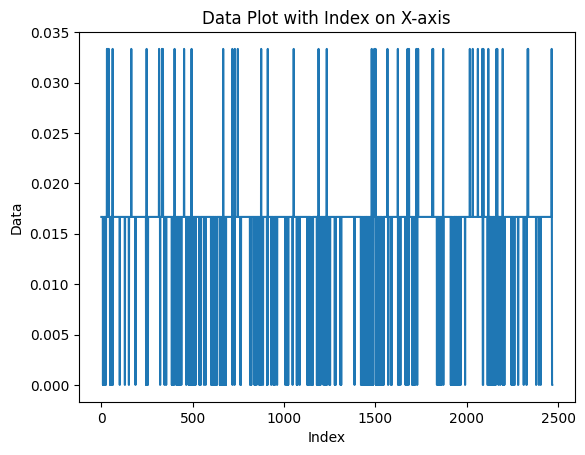

In [40]:
plt.plot(empty_list)
plt.xlabel('Index')
plt.ylabel('Data')
plt.title('Data Plot with Index on X-axis')
plt.show()

In [36]:
set(empty_list)

{0.0,
 0.016666666666666666,
 0.03333333333333333,
 0.05,
 0.06666666666666667,
 0.08333333333333333}

In [23]:
data = {'Col1': range(1, 11),
        'Col2': np.random.randint(1, 6, 10)}  # Random integers between 1 and 5 for Col2
df = pd.DataFrame(data)
df.head(1000)

,Col1,Col2
0,1,4
1,2,3
2,3,2
3,4,2
4,5,2
5,6,3
6,7,5
7,8,2
8,9,4
9,10,3


In [16]:
initial_rows = 60  # Change this according to your requirements
initial_subset = df.iloc[:initial_rows]
ipa_calculator = IPA(initial_subset)
ipa_lister = []
world_index_lister = []

for i in range(initial_rows, len(df)):
    subset = df.iloc[:i+1]  # Increase the subset of data
    ipa_calculator = IPA(subset)  # Calculate IPA for the current subset
    ipa_lister.append(ipa_calculator.ipa)
    world_index_lister.append(subset['world_index'].iloc[-1])

C:\Users\cdhye\anaconda3\envs\New_ENV\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculat

IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
I

IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculat

IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculation: 0.016666666666666666
IPA Calculat

IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
IPA Calculation: 0.03333333333333333
I

In [34]:
window_size = 60

if window_size > len(df):
    raise ValueError("Window size is greater than the length of the dataframe")

# Calculate sliding window average and latest Col1 value
result_df = sliding_window_average(df, window_size)

print(result_df)

      Window_Avg  Latest_Col1
0      52.582707        130.0
1      52.649670        131.0
2      52.717620        132.0
3      52.783592        133.0
4      52.826862        134.0
...          ...          ...
1662   49.465442       1792.0
1663   49.518748       1793.0
1664   49.577628       1794.0
1665   49.636997       1795.0
1666   49.696636       1796.0

[1667 rows x 2 columns]


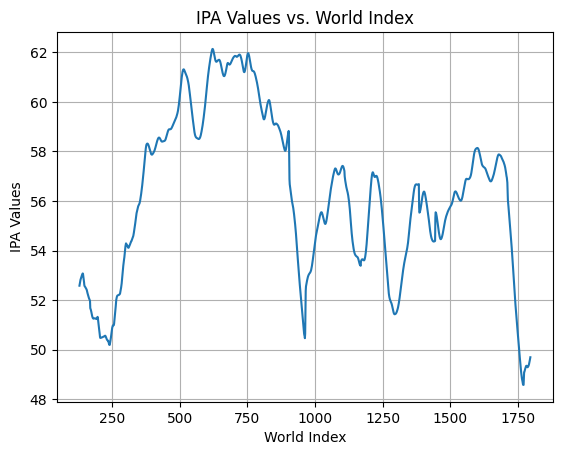

In [37]:
plt.plot(result_df['Latest_Col1'], result_df['Window_Avg'], linestyle='-')
plt.title('IPA Values vs. World Index')
plt.xlabel('World Index')
plt.ylabel('IPA Values')
plt.grid(True)
plt.show()

In [ ]:
Latest_Col1